- To do inference within the notebook:
    1. Put all images in a directory.
    2. In the last cell of the notebook, set the input_folder_vlm variable to the directory where the images are kept.        
    3. Set the json_output_folder variable to a directory where the JSON files should be saved. This folder will be create automatically.
    4. Set the VLM_BATCH_SIZE according to the available GPU memory. [24GB VRAM can handle batch size of upto 6]
    5. Run all the cells in the notebook, the inference will be carried out in the final cell.
        1. Ensure the YOLOv5 model has been downloaded. This should be automatically done when you run the code in the ‘Setup Environment’ section of the notebook. If it does not work, then follow the instructions on the notebook and download the YOLO model in the same directory as the notebook.
    6. If you want to do inference with the base model (instead of the finetuned model), set the use_finetuned variable in the first cell to False.
    7. To speed up inference, you can also disable Chain of Thought in the output by setting cot = False

# Use Finetuned or Base Model
Set the use_finetuned model to True to do infernece using the finetuned model. If it is set to False, inference will be done using the base model of Qwen.

In [ ]:
use_finetuned = False
cot = False

# Setup Environment

In [ ]:
#this will install the required libraries. If you are not using Google Colab, additional libraries may need to be installed, specially pytorch and tranformers.
!pip install -q accelerate qwen-vl-utils seaborn bitsandbytes pyyaml ultralytics hf_xet peft json5

In [ ]:
#these lines will ignore any unnecessary warnings, keeping our workspace clean
import warnings
import os
warnings.filterwarnings("ignore")

In [ ]:
#this will download 3 sample images and put them in a folder named "input_folder"
#the following commands will only work on a linux environment (such as colab)
#if you are running locally on windows, please manually put any sample images in a folder and name it 'input_images'
!gdown --id 17PI4UeX2tDR2YDbWsRdVKFCECR9eYQ4_ -O file.zip
!unzip file.zip -d input_images

#the following downloads a yolov5 model to detect vehicles
!gdown --id 1SrbA34-ptAA7Nm92TpCcHMn3lvwh-EKh

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=17PI4UeX2tDR2YDbWsRdVKFCECR9eYQ4_
To: /content/file.zip
100% 817k/817k [00:00<00:00, 95.9MB/s]
Archive:  file.zip
replace input_images/images/28229480.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace input_images/images/28308283.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace input_images/images/28313905.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1SrbA34-ptAA7Nm92TpCcHMn3lvwh-EKh
From (redirected): https://drive.google.com/uc?id

If the above code block doesn't work, you can download the YOLOv5 model from here: https://drive.google.com/file/d/1SrbA34-ptAA7Nm92TpCcHMn3lvwh-EKh/view?usp=drive_link

# Imports

In [ ]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch
from IPython.display import Markdown, display
import re
from peft import PeftModel
import json
import json5
import time
from pathlib import Path
import cv2
from tqdm import tqdm
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## JSON Parser
JSON objects have a specific syntax that must be followed so that they can be accurately parsed. LLMs may not always output the accurate syntax. The following function is used to ensure the JSON output from the LLM has proper syntax. The function takes the LLM's output and outputs a proper JSON object. We call this function in a later part of the code.

In [ ]:
def normalize_json5(s: str, img_name):
    """
    Strip markdown fences and parse using json5 for lenient JSON parsing.
    Returns the Python object on success or None on failure.
    """
    # Remove any ``` or ```json code fences
    s = re.sub(r"```(?:json)?\s*([\s\S]*?)```", r"\1", s).strip()
    try:
        return json5.loads(s)
    except Exception as e:
        print(f"normalize_json5: failed to parse input as JSON5 for image: {img_name}.") # MODIFIED
        print("Error message:", str(e))
        # Optionally log the faulty string:
        print("Faulty string content:")
        print(s)
        # print(f"Image: {img_name}") # This was already here, good.
        return None

## Model and Processor
We are using the model found in this link: https://huggingface.co/unsloth/Qwen2.5-VL-3B-Instruct-bnb-4bit

The original model is from Qwen, but it has been quantized by unsloth using a quantization library called BitsAndBytes

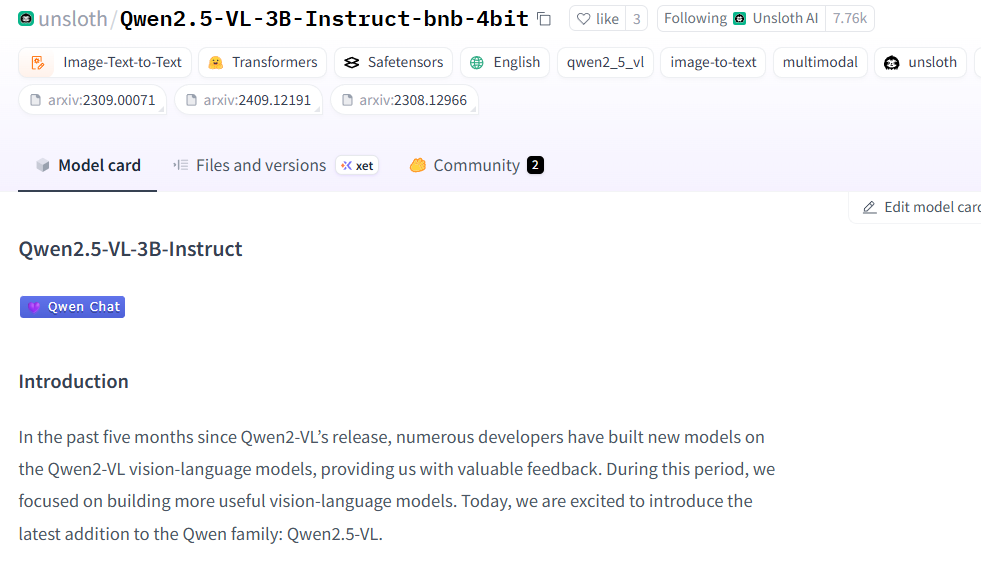

In [ ]:
#Base (unfine‑tuned) model
#we are using a 4-bit quantized version of Qwen 2.5VL 3B
#the model id is found from the huggingface model page
BASE_MODEL_ID = "unsloth/Qwen2.5-VL-3B-Instruct-bnb-4bit"

#Downloading and loading the model on the GPU. This will load the original model
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    BASE_MODEL_ID,
    device_map="cuda",
    torch_dtype=torch.bfloat16
)

#now we will load the model specific tokenizer. each model has it's own tokenizer
min_pixels = 256*28*28
max_pixels = 1280*28*28
#the min and max pixel values set the upper and lower limits for the resolution of images allowed
#any image outside this range will be auto scaled
processor = AutoProcessor.from_pretrained(BASE_MODEL_ID, min_pixels=min_pixels, max_pixels=max_pixels)

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


In [ ]:
#Now we will load the LoRA adapters of a finetuned model. This adapters are attached
#to the base model we loaded
LORA_REPO = "muqtasid87/qwen2.5-filtered-data-qv-final-push" #the lora adapters are on huggingface

#the following block will only run if you have set use_finetuned = True in the first cell
if use_finetuned:
  model = PeftModel.from_pretrained(
      model,                     # pass base model
      LORA_REPO,
      is_trainable=False,             # inference only
  ).to(DEVICE)

# System and User Prompts

In [ ]:
if cot:
  system_prompt = """
  You are a vehicle‑vision expert. Given one image of a single vehicle, you must:
  1. Visual Observation & Chain of Thought (CoT): Systematically observe and describe all discernible visual features of the vehicle. Be highly detailed and specific,
    focusing on attributes relevant to classification (e.g., body style, number of doors, roofline, ground clearance, wheel/axle count, cargo area, specialized equipment, visible markings).
    Explain your step-by-step reasoning process for each classification decision, explicitly linking visual cues to the chosen categories and attributes. Compare all possible categories with the
    visual cues.
  2. Category Classification: Identify the most appropriate main Category from the Unified Vehicle Taxonomy provided in the user prompt.
  3. Subcategory Classification: Identify the most appropriate fine-grained Subcategory under the chosen Category from the Unified Vehicle Taxonomy.
    If no specific subcategory is visually discernible or applicable, output "General".
  4. Attribute Extraction: Count visible wheels, infer the number of axles, and identify specific boolean attributes (Is_taxi, Is_school_bus, Is_emergency_vehicle, License_plate_visible).
  5. Output ONLY a JSON object with only the given keys.

  Do NOT output any other text.
  """
else:
  system_prompt = """
  You are a vehicle‑vision expert. Given one image of a single vehicle, you must:
  1. Category Classification: Identify the most appropriate main Category from the Unified Vehicle Taxonomy provided in the user prompt.
  2. Subcategory Classification: Identify the most appropriate fine-grained Subcategory under the chosen Category from the Unified Vehicle Taxonomy.
    If no specific subcategory is visually discernible or applicable, output "General".
  3. Attribute Extraction: Count visible wheels, infer the number of axles, and identify specific boolean attributes (Is_taxi, Is_school_bus, Is_emergency_vehicle, License_plate_visible).
  4. Output ONLY a JSON object with only the given keys.

  Do NOT output any other text.
  """

In [ ]:
if cot:
  user_prompt = """
  Analyze the vehicle in this image and output a structured JSON with fine-grained classification based on the provided Unified Vehicle Taxonomy and visual cues.
  Use detailed reasoning steps in 'CoT' to explain your decision. If you are unable to confidently classify the vehicle based on the visual information,
  set 'Category' and 'Subcategory' to 'Unclassified'.

  **Unified Vehicle Taxonomy:**
  1. Unclassified  - vehicle not confidently identifiable
      • Used when the vehicle cannot be confidently classified into any defined category based on visual cues (e.g., due to poor image quality, occlusion, or ambiguity, or the vehicle not belonging to any of the given classes).
  2. Car – standard passenger vehicles
      • Sedan (Low-profile, elongated body with a distinct three-box silhouette: separate sections for engine, cabin, and trunk. Usually has four doors.)
      • Hatchback (Compact body with a sloping rear roofline.)
      • Coupe (Two-door layout with a short, sloped roof and a sporty, compact profile. Rear passenger space is visually smaller or limited.)
      • Convertible (Vehicle with a visibly retractable or absent roof.)
      • Sports (Aggressively styled, low-ground-clearance vehicle with wide stance, aerodynamic body lines, large wheels, and often two doors.)
  3. SUV – taller chassis, off‑road capability
      • Compact_SUV (Small, tall-bodied vehicle with short overhangs, high ground clearance, and rugged cladding. Compact proportions compared to full-size SUVs.)
      • Mid‑Size_SUV (Moderate size with tall roofline, bold grille, and larger wheels. Typically appears more muscular than compact variants.)
      • Full‑Size_SUV (Large and boxy with a high roofline, prominent grille, wide stance, and often roof rails. Rear often includes large vertical tail lights.)
      • Crossover (Curved and car-like silhouette with a taller ride height. Smooth body lines and smaller gaps between wheels and body.)
  4. MPV_Small – small multi‑purpose vans
      • Compact_MPV (Tall, narrow-bodied vehicle with a short hood and vertical rear end. Often features sliding doors and large glass areas.)
      • Minivan (Rounded, spacious-looking body with a long roofline and visibly large side windows. Typically has sliding rear doors.)

  5. MPV_Big – large multi‑purpose vans
      • Large_MPV (Bulky, tall profile with extended rear overhang and large windows. Wide stance with premium-looking body finishes.)
      • 7‑Seater_MPV (Similar to Large_MPV but may show visual hints of interior layout such as larger rear side windows for third-row access.)
  6. Pickup_Truck – open cargo bed
      • Regular_Cab (Two-door truck with a small cabin and visibly long, open cargo bed. Clear separation between cab and bed.)
      • Extended_Cab (Visibly longer cab than regular version, sometimes with small rear doors. Cargo bed is medium length.)
      • Crew_Cab (Four full-size doors, full rear seating area, and slightly shorter bed. Balanced length between cabin and cargo area.)
  7. Bus – passenger transport
      • City_Bus (Long, boxy structure with wide doors (usually two or more), large windows, and low ground clearance.)
      • Coach (Sleek and elongated body with high windows, luggage compartments beneath, and a streamlined roofline. long‑distance, luggage bays)
      • School_Bus (Boxy, mid-length vehicle with a protruding front nose and high visibility features)
  8. Motorcycle – two‑wheeled motor vehicles, slim and small silhoutte, usually single headlights
      • Motorbike (standard bike)
      • Scooter (step‑through frame)
  9. Vans – enclosed cargo/passenger vans
      • Cargo_Van (Boxy rear with few or no side windows in the cargo area. Minimal visual separation between cab and cargo body.)
      • Passenger_Van (Boxy or slightly curved body with multiple side windows and visible seating rows through windows.)
  10. Small_Truck – small 2‑axle commercial
      • 2‑Axle_Small (Boxy or cab-over-engine design with visible dual rear wheels. 2 wheels per axles and compact cargo body.)
      • 2-Axle_Big - (Larger than 2_Axle_Small, 4 rear wheels usually.)
  11. Medium_Truck – medium 3‑axle commercial
      • 3‑Axle_Medium (moderate cargo, Larger than 2-axle trucks, often with sleeper cab or larger cargo box. more robust body.)
  12. Large_Truck – large 4‑axle commercial
      • 4‑Axle_Large (heavy cargo, Very long frame with high ground clearance, extended wheelbase. Heavy-duty build with visible reinforced chassis.)
  13. Heavy_Truck – heavy‑duty >5 axles
      • 5+_Axle_Heavy (very heavy loads, Extra-long chassis with multiple connected trailer sections or components. highly segmented and reinforced appearance.)
  14. Construction_and_Industrial – specialized machinery
      • Bulldozer (Heavy tracked vehicle with a wide, flat metal blade at the front. Compact and powerful-looking body.)
      • Excavator (Tracked or wheeled vehicle with a long articulated arm ending in a bucket. Rotating cab and counterweight at the rear.)
      • Crane (Tall and narrow profile with a boom or arm extending upward or outward. Often mounted on a truck or mobile base.)
      • Forklift (Small, compact industrial vehicle with upright forks at the front and a protective overhead cage.)
      • Dump_Truck (Large, boxy bed with visible rear hinge and hydraulic lift system. High ground clearance and chunky tires.)
      • Mixer (Truck with a large, rotating drum mounted on the rear. Drum is tilted and often striped or textured.)
  15. Tanker – liquid cargo trailers
      • Fuel_Tanker (Smooth, cylindrical tank mounted on a truck or trailer. Usually has visible valves and side or rear hatches.)
      • Chemical_Tanker (Cylindrical tank with additional external piping, valves, and often hazmat signage.)
      • Gas_Tanker (Rounded or bullet-shaped tank with extra reinforcement bands. May have insulated or pressurized appearance.)
  16. Container – intermodal shipping boxes
      • 20ft_Container (Short rectangular metal box with corner fittings. Often marked with codes or shipping logos. Proportions clearly shorter than 40ft variant.)
      • 40ft_Container (Longer rectangular metal box with similar structure to 20ft but visually stretched. Usually spans most of a trailer.)
  17. Trailer – unpowered cargo carriers
      • Flatbed_Trailer (Open, flat platform with no walls or roof.)
      • Car_Carrier (Double-decked or angled trailer frame with visible ramps and slots for securing vehicles.)
      • Lowboy_Trailer (Trailer with a distinct drop in deck height between the gooseneck and rear wheels. Allows transport of tall equipment.)
      • Refrigerator_Trailer (Boxy, fully enclosed trailer with smooth sides and a visible refrigeration unit (often front-mounted).)

  **Output JSON keys & descriptors:**
      1. **CoT**: Your step-by-step observations of all the details of the vehicle, explicitly linking visual cues to classification decisions. If the vehicle is unclassified, explain why classification was not possible (e.g., "Image too blurry," "Vehicle heavily obscured").
      2. **Category**: The main vehicle type, chosen from the **Unified Vehicle Taxonomy**. Output "Unclassified" if the vehicle cannot be confidently classified.
      3. **Subcategory**: The fine-grained vehicle type, chosen from the **Unified Vehicle Taxonomy**. If not applicable or visually discernible, output "General". Output "Unclassified" if the vehicle cannot be confidently classified.
      4. **Number_of_wheels_visible**: An integer count of all wheels clearly visible in the image. Output 0 if the vehicle is Unclassified or no wheels are visible.
      5. **Number_of_axles_inferred_from_number_of_wheels**: An integer representing the inferred number of axles based on the visible wheels and vehicle type. For passenger vehicles, 2 wheels visible on one side typically implies 2 axle. For trucks and heavy vehicles, infer axles based on visible wheel sets. Consider dual wheels as a single wheel set for axle inference. Output 0 if the vehicle is Unclassified or axles cannot be inferred.
      6. **Is_taxi**: A boolean (true/false). True if clear commercial taxi markings are visible (e.g., rooftop sign, specific livery, visible taxi meter, company logo). False otherwise.
      7. **Is_school_bus**: A boolean (true/false). True if the vehicle is clearly identifiable as a school bus (e.g., distinct yellow color, "SCHOOL BUS" signage, stop sign arm, specific seating design). False otherwise.
      8. **Is_emergency_vehicle**: A boolean (true/false). True if clear emergency vehicle markings are visible (e.g., siren, light bar, official police/ambulance/fire insignia, distinct emergency vehicle colors). False otherwise.
      9. **License_plate_visible**: A boolean (true/false). True if a license plate is clearly visible and readable in the image. False otherwise.

  JSON OUTPUT FORMAT EXAMPLE:

      {
        "CoT": "...",
        "Category": "...",
        "Subcategory": "...",
        "Number_of_wheels_visible": 0,
        "Number_of_axles_inferred_from_number_of_wheels": 0,
        "Is_taxi": false,
        "Is_school_bus": false,
        "Is_emergency_vehicle": false,
        "License_plate_visible": false
      }

  """
else:
  user_prompt = """
  Analyze the vehicle in this image and output a structured JSON with fine-grained classification based on the provided Unified Vehicle Taxonomy and visual cues.
  If you are unable to confidently classify the vehicle based on the visual information,
  set 'Category' and 'Subcategory' to 'Unclassified'.

  **Unified Vehicle Taxonomy:**
  1. Unclassified  - vehicle not confidently identifiable
      • Used when the vehicle cannot be confidently classified into any defined category based on visual cues (e.g., due to poor image quality, occlusion, or ambiguity, or the vehicle not belonging to any of the given classes).
  2. Car – standard passenger vehicles
      • Sedan (Low-profile, elongated body with a distinct three-box silhouette: separate sections for engine, cabin, and trunk. Usually has four doors.)
      • Hatchback (Compact body with a sloping rear roofline.)
      • Coupe (Two-door layout with a short, sloped roof and a sporty, compact profile. Rear passenger space is visually smaller or limited.)
      • Convertible (Vehicle with a visibly retractable or absent roof.)
      • Sports (Aggressively styled, low-ground-clearance vehicle with wide stance, aerodynamic body lines, large wheels, and often two doors.)
  3. SUV – taller chassis, off‑road capability
      • Compact_SUV (Small, tall-bodied vehicle with short overhangs, high ground clearance, and rugged cladding. Compact proportions compared to full-size SUVs.)
      • Mid‑Size_SUV (Moderate size with tall roofline, bold grille, and larger wheels. Typically appears more muscular than compact variants.)
      • Full‑Size_SUV (Large and boxy with a high roofline, prominent grille, wide stance, and often roof rails. Rear often includes large vertical tail lights.)
      • Crossover (Curved and car-like silhouette with a taller ride height. Smooth body lines and smaller gaps between wheels and body.)
  4. MPV_Small – small multi‑purpose vans
      • Compact_MPV (Tall, narrow-bodied vehicle with a short hood and vertical rear end. Often features sliding doors and large glass areas.)
      • Minivan (Rounded, spacious-looking body with a long roofline and visibly large side windows. Typically has sliding rear doors.)

  5. MPV_Big – large multi‑purpose vans
      • Large_MPV (Bulky, tall profile with extended rear overhang and large windows. Wide stance with premium-looking body finishes.)
      • 7‑Seater_MPV (Similar to Large_MPV but may show visual hints of interior layout such as larger rear side windows for third-row access.)
  6. Pickup_Truck – open cargo bed
      • Regular_Cab (Two-door truck with a small cabin and visibly long, open cargo bed. Clear separation between cab and bed.)
      • Extended_Cab (Visibly longer cab than regular version, sometimes with small rear doors. Cargo bed is medium length.)
      • Crew_Cab (Four full-size doors, full rear seating area, and slightly shorter bed. Balanced length between cabin and cargo area.)
  7. Bus – passenger transport
      • City_Bus (Long, boxy structure with wide doors (usually two or more), large windows, and low ground clearance.)
      • Coach (Sleek and elongated body with high windows, luggage compartments beneath, and a streamlined roofline. long‑distance, luggage bays)
      • School_Bus (Boxy, mid-length vehicle with a protruding front nose and high visibility features)
  8. Motorcycle – two‑wheeled motor vehicles, slim and small silhoutte, usually single headlights
      • Motorbike (standard bike)
      • Scooter (step‑through frame)
  9. Vans – enclosed cargo/passenger vans
      • Cargo_Van (Boxy rear with few or no side windows in the cargo area. Minimal visual separation between cab and cargo body.)
      • Passenger_Van (Boxy or slightly curved body with multiple side windows and visible seating rows through windows.)
  10. Small_Truck – small 2‑axle commercial
      • 2‑Axle_Small (Boxy or cab-over-engine design with visible dual rear wheels. 2 wheels per axles and compact cargo body.)
      • 2-Axle_Big - (Larger than 2_Axle_Small, 4 rear wheels usually.)
  11. Medium_Truck – medium 3‑axle commercial
      • 3‑Axle_Medium (moderate cargo, Larger than 2-axle trucks, often with sleeper cab or larger cargo box. more robust body.)
  12. Large_Truck – large 4‑axle commercial
      • 4‑Axle_Large (heavy cargo, Very long frame with high ground clearance, extended wheelbase. Heavy-duty build with visible reinforced chassis.)
  13. Heavy_Truck – heavy‑duty >5 axles
      • 5+_Axle_Heavy (very heavy loads, Extra-long chassis with multiple connected trailer sections or components. highly segmented and reinforced appearance.)
  14. Construction_and_Industrial – specialized machinery
      • Bulldozer (Heavy tracked vehicle with a wide, flat metal blade at the front. Compact and powerful-looking body.)
      • Excavator (Tracked or wheeled vehicle with a long articulated arm ending in a bucket. Rotating cab and counterweight at the rear.)
      • Crane (Tall and narrow profile with a boom or arm extending upward or outward. Often mounted on a truck or mobile base.)
      • Forklift (Small, compact industrial vehicle with upright forks at the front and a protective overhead cage.)
      • Dump_Truck (Large, boxy bed with visible rear hinge and hydraulic lift system. High ground clearance and chunky tires.)
      • Mixer (Truck with a large, rotating drum mounted on the rear. Drum is tilted and often striped or textured.)
  15. Tanker – liquid cargo trailers
      • Fuel_Tanker (Smooth, cylindrical tank mounted on a truck or trailer. Usually has visible valves and side or rear hatches.)
      • Chemical_Tanker (Cylindrical tank with additional external piping, valves, and often hazmat signage.)
      • Gas_Tanker (Rounded or bullet-shaped tank with extra reinforcement bands. May have insulated or pressurized appearance.)
  16. Container – intermodal shipping boxes
      • 20ft_Container (Short rectangular metal box with corner fittings. Often marked with codes or shipping logos. Proportions clearly shorter than 40ft variant.)
      • 40ft_Container (Longer rectangular metal box with similar structure to 20ft but visually stretched. Usually spans most of a trailer.)
  17. Trailer – unpowered cargo carriers
      • Flatbed_Trailer (Open, flat platform with no walls or roof.)
      • Car_Carrier (Double-decked or angled trailer frame with visible ramps and slots for securing vehicles.)
      • Lowboy_Trailer (Trailer with a distinct drop in deck height between the gooseneck and rear wheels. Allows transport of tall equipment.)
      • Refrigerator_Trailer (Boxy, fully enclosed trailer with smooth sides and a visible refrigeration unit (often front-mounted).)

  **Output JSON keys & descriptors:**
      1. **Category**: The main vehicle type, chosen from the **Unified Vehicle Taxonomy**. Output "Unclassified" if the vehicle cannot be confidently classified.
      2. **Subcategory**: The fine-grained vehicle type, chosen from the **Unified Vehicle Taxonomy**. If not applicable or visually discernible, output "General". Output "Unclassified" if the vehicle cannot be confidently classified.
      3. **Number_of_wheels_visible**: An integer count of all wheels clearly visible in the image. Output 0 if the vehicle is Unclassified or no wheels are visible.
      4. **Number_of_axles_inferred_from_number_of_wheels**: An integer representing the inferred number of axles based on the visible wheels and vehicle type. For passenger vehicles, 2 wheels visible on one side typically implies 2 axle. For trucks and heavy vehicles, infer axles based on visible wheel sets. Consider dual wheels as a single wheel set for axle inference. Output 0 if the vehicle is Unclassified or axles cannot be inferred.
      5. **Is_taxi**: A boolean (true/false). True if clear commercial taxi markings are visible (e.g., rooftop sign, specific livery, visible taxi meter, company logo). False otherwise.
      6. **Is_school_bus**: A boolean (true/false). True if the vehicle is clearly identifiable as a school bus (e.g., distinct yellow color, "SCHOOL BUS" signage, stop sign arm, specific seating design). False otherwise.
      7. **Is_emergency_vehicle**: A boolean (true/false). True if clear emergency vehicle markings are visible (e.g., siren, light bar, official police/ambulance/fire insignia, distinct emergency vehicle colors). False otherwise.
      8. **License_plate_visible**: A boolean (true/false). True if a license plate is clearly visible and readable in the image. False otherwise.

  JSON OUTPUT FORMAT EXAMPLE:

      {
        "Category": "...",
        "Subcategory": "...",
        "Number_of_wheels_visible": 0,
        "Number_of_axles_inferred_from_number_of_wheels": 0,
        "Is_taxi": false,
        "Is_school_bus": false,
        "Is_emergency_vehicle": false,
        "License_plate_visible": false
      }

  """

# YOLO Detector Functions
The code in this section is used for detecting the vehicles in the image in the first step.

In [ ]:
import os
import json
import cv2
import numpy as np
from pathlib import Path
import uuid
from ultralytics import YOLO
import base64

#path to downloaded YOLOv5 model
model_path = r'best_avc_v5.pt'

In [ ]:
def detect_vehicles_yolo_v5(image, model, conf_threshold=0.1):
    """
    Detect vehicles in an image using YOLOv5 model.

    Args:
        image_filename (str): Name of the image file (for reference)
        image (numpy.ndarray): Input image
        model_path (str): Path to YOLOv5 model weights
        conf_threshold (float): Confidence threshold for detections

    Returns:
        list: List of dictionaries containing detection information
    """

    # Custom class names mapping
    class_names = {
        1: 'class1_lightVehicle',
        2: 'class2_mediumVehicle',
        3: 'class3_heavyVehicle',
        4: 'class4_taxi',
        5: 'class5_bus',
        6: 'class_motocycle'
    }

    # Vehicle classes
    vehicle_classes = [1, 2, 3, 4, 5, 6]  # we want the model to detect all the classes it has been trained on

    # Get image dimensions
    img_height, img_width = image.shape[:2]

    # Initialize list to store vehicle detections
    vehicle_detections = []

    try:
        # Run inference
        results = model(image)

        # Parse results
        detections = results.pandas().xyxy[0]  # Get detections as pandas DataFrame

        for _, detection in detections.iterrows():
            class_id = int(detection['class'])
            confidence = float(detection['confidence'])

            # Skip if not a vehicle class or below confidence threshold
            if class_id not in vehicle_classes or confidence < conf_threshold:
                continue

            # Get bounding box coordinates
            x1 = int(detection['xmin'])
            y1 = int(detection['ymin'])
            x2 = int(detection['xmax'])
            y2 = int(detection['ymax'])

            # Ensure coordinates are within image bounds
            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(img_width, x2)
            y2 = min(img_height, y2)

            # Skip if bounding box is invalid
            if x2 <= x1 or y2 <= y1:
                continue

            # Get class name
            class_name = class_names.get(class_id, f"class_{class_id}")

            # Create a unique ID for this detection
            detection_id = str(uuid.uuid4())

            # Crop the vehicle from the image
            vehicle_crop = image[y1:y2, x1:x2]

            # Skip if crop is empty
            if vehicle_crop.size == 0:
                continue

            # Convert crop to base64
            base64_crop = numpy_to_base64(vehicle_crop)

            # Store detection info
            detection = {
                "detection_id": detection_id,
                "bounding_box": {
                    "x1": x1,
                    "y1": y1,
                    "x2": x2,
                    "y2": y2,
                    "width": x2 - x1,
                    "height": y2 - y1
                },
                "class": class_name,
                "class_id": class_id,
                "confidence": confidence,
                "crop_base64": base64_crop
            }

            vehicle_detections.append(detection)

    except Exception as e:
        print(f"Error during inference: {str(e)}")
        return []

    return vehicle_detections

#each cropped region is saved as a numpy array
#so we need to convert to base64 to pass into VLM
#the below function is called within the function above
def numpy_to_base64(image):
    """
    Convert a numpy array image to a base64 encoded string.

    Args:
        image (numpy.ndarray): Image as numpy array

    Returns:
        str: Base64 encoded string
    """
    # Encode the numpy array to jpg format
    success, encoded_img = cv2.imencode('.jpg', image)
    if not success:
        return None

    # Convert the binary data to base64 string
    base64_data = base64.b64encode(encoded_img.tobytes()).decode('utf-8')

    # Format as data URL
    return f"data:image/jpeg;base64,{base64_data}"

Function to combine YOLO regions with VLM inferences

In [ ]:
# function to combine metadata with the inference from the VLM and create a JSON file for every image
def create_image_json(image_path, image, detections):
    """
    Create a JSON object for an image with all its detections.

    Args:
        image_path (Path): Path to the image file
        image (numpy.ndarray): The image array
        detections (list): List of detection dictionaries with inference results

    Returns:
        dict: Image results as a JSON-serializable dictionary
    """
    # Create the image results dictionary
    image_results = {
        "image_filename": image_path.name,
        "image_path": str(image_path),
        "image_dimensions": {
            "width": image.shape[1],
            "height": image.shape[0],
            "channels": image.shape[2]
        },
        "detection_count": len(detections),
        "detections": detections,
    }

    return image_results

# VLM Inference Functions

### Base64 to PIL

In [ ]:
import base64
from io import BytesIO
from PIL import Image

# Helper function to convert base64 string to PIL Image
def base64_to_pil(base64_str):
    # Remove the "data:image/jpeg;base64," part if present
    if "base64," in base64_str:
        base64_str = base64_str.split("base64,")[1]
    try:
        image_data = base64.b64decode(base64_str)
        image = Image.open(BytesIO(image_data))
        return image
    except Exception as e:
        print(f"Error decoding base64 string or opening image: {e}")
        # print(f"Problematic base64 string (first 100 chars): {base64_str[:100]}") # For debugging
        return None

### Batched VLM Inference

In [ ]:
def vlm_fine_grained_inference_batched(
    imgs_base64_list,
    system_prompt_text=system_prompt,
    user_prompt_text=user_prompt,
    img_names_list=None # Added for error reporting
):
    batch_size = len(imgs_base64_list)
    if batch_size == 0:
        return []

    if img_names_list is None:
        # Create dummy names if not provided, for consistent error reporting
        img_names_list = [f"image_in_batch_{i}" for i in range(batch_size)]
    elif len(img_names_list) != batch_size:
        # Fallback if img_names_list is provided but has incorrect length
        print("Warning: img_names_list length mismatch. Using generic names for error reporting.")
        img_names_list = [f"image_in_batch_{i}" for i in range(batch_size)]


    batched_messages_for_template = []
    pil_images_for_processor = []

    for i, img_b64 in enumerate(imgs_base64_list):
        pil_image = base64_to_pil(img_b64)
        current_img_name = img_names_list[i] if img_names_list and i < len(img_names_list) else f"unknown_image_at_batch_idx_{i}"

        if pil_image is None:
            print(f"Warning: Failed to convert base64 image to PIL for {current_img_name}. Skipping its VLM processing.")
            current_item_messages = [
                {"role": "system", "content": f"Error: Image {current_img_name} could not be processed."},
                {"role": "user", "content": [{"type": "text", "text": f"Error in image {current_img_name}."}]}
            ]
            pil_images_for_processor.append(None)
        else:
            pil_images_for_processor.append(pil_image)
            current_item_messages = [
                {"role": "system", "content": system_prompt_text},
                {
                    "role": "user",
                    "content": [
                        {"type": "image"},
                        {"type": "text",  "text": user_prompt_text}
                    ]
                }
            ]

        text_for_item = processor.apply_chat_template(
            current_item_messages, tokenize=False, add_generation_prompt=True
        )
        batched_messages_for_template.append(text_for_item)

    valid_indices = [i for i, img in enumerate(pil_images_for_processor) if img is not None]
    if not valid_indices:
        print("Error: All images in batch failed to convert from base64.")
        error_msg_template = '{{"error": "Image conversion failed for all items in batch. First image name in batch: {}"}}'
        first_img_name = img_names_list[0] if img_names_list else "N/A"
        return [normalize_json5(error_msg_template.format(first_img_name), first_img_name)] * batch_size


    final_pil_images = [pil_images_for_processor[i] for i in valid_indices]
    final_texts = [batched_messages_for_template[i] for i in valid_indices]

    if len(final_pil_images) != len(final_texts):
        raise ValueError("Mismatch between number of valid images and texts after filtering.")

    if not final_pil_images:
        error_msg_template = '{{"error": "Image conversion failed for all items in batch. First image name in batch: {}"}}'
        first_img_name = img_names_list[0] if img_names_list else "N/A"
        return [normalize_json5(error_msg_template.format(first_img_name), first_img_name)] * batch_size


    inputs = processor(
        text=final_texts,
        images=final_pil_images,
        videos=None,
        padding=True,
        return_tensors="pt",
    ).to("cuda", dtype=torch.float16)

    generated_ids = model.generate(
        **inputs,
        max_new_tokens=768,
        do_sample=False
    )

    trimmed = [out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]

    decoded_outputs_for_valid_items = processor.batch_decode(
        trimmed, skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )

    final_results_full_batch = [None] * batch_size
    valid_output_idx = 0
    for original_idx in range(batch_size):
        current_img_name = img_names_list[original_idx] if img_names_list and original_idx < len(img_names_list) else f"unknown_image_at_original_idx_{original_idx}"
        if original_idx in valid_indices:
            if valid_output_idx < len(decoded_outputs_for_valid_items):
                final_results_full_batch[original_idx] = normalize_json5(
                    decoded_outputs_for_valid_items[valid_output_idx],
                    current_img_name # Pass img_name here
                )
                valid_output_idx += 1
            else:
                final_results_full_batch[original_idx] = normalize_json5(
                    '{"error": "Internal processing error, missing VLM output."}',
                    current_img_name # Pass img_name here
                )
        else:
            final_results_full_batch[original_idx] = normalize_json5(
                '{"error": "Image conversion failed."}',
                current_img_name # Pass img_name here
            )

    return final_results_full_batch

# Process Images (Putting detection and VLM inference together)

In [ ]:
def process_images_true_batching(input_folder, output_folder, model=model_path, conf_threshold=0.1, vlm_batch_size=2):

    # Load YOLOv5 model
    try:
        # Try with force_reload first
        model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_path, force_reload=True)
        model.conf = conf_threshold
    except Exception as e1:
        try:
            # Alternative: load directly with torch.load if custom model
            model = torch.load(model_path, map_location='cpu')
            if hasattr(model, 'conf'):
                model.conf = conf_threshold
        except Exception as e2:
            print(f"Error loading model with torch.hub: {str(e1)}")
            print(f"Error loading model with torch.load: {str(e2)}")
            return []

    os.makedirs(output_folder, exist_ok=True)
    image_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
    all_input_files = [p for ext in image_exts for p in Path(input_folder).glob(f'*{ext}')]
    print(f"Found {len(all_input_files)} images in '{input_folder}'")
    start_all_time = time.perf_counter()

    all_images_data = {} # Stores {'img_path_str': {'img_cv2': img_obj_or_None, 'yolo_detections_with_vlm': []}}


    # Stores items for VLM batching:
    # [{'crop_b64': b64_str, 'img_name_for_vlm': "original_image_name_crop_0", 'image_path_str': img_path, 'original_det_idx': det_idx, 'yolo_det_obj': yolo_det_dict_without_crop}]
    crops_to_vlm_batch = []

    processed_image_count = 0
    total_yolo_detections_count = 0
    total_vlm_inferences_done = 0

    # --- Stage 1: Iterate images, run YOLO, collect crops ---
    for img_path in tqdm(all_input_files, desc="YOLO & Crop Collection", unit="img"):
        img_path_str = str(img_path)
        img_name = img_path.name # For VLM error reporting

        img = cv2.imread(img_path_str)
        if img is None:
            tqdm.write(f"[SKIP] Could not read '{img_name}'")
            all_images_data[img_path_str] = {'img_cv2': None, 'yolo_detections_with_vlm': []}
            continue

        all_images_data[img_path_str] = {'img_cv2': img, 'yolo_detections_with_vlm': []}

        yolo_detections_current_image = detect_vehicles_yolo_v5(img, model, conf_threshold=0.1)
        total_yolo_detections_count += len(yolo_detections_current_image)

        for det_idx, yolo_det_obj in enumerate(yolo_detections_current_image):
            crop_b64 = yolo_det_obj.pop("crop_base64", None)
            if crop_b64:
                crops_to_vlm_batch.append({
                    'crop_b64': crop_b64,
                    'img_name_for_vlm': f"{img_name}_crop_{det_idx}", # Specific name for this crop
                    'image_path_str': img_path_str,
                    'original_det_idx': det_idx,
                    'yolo_det_obj': yolo_det_obj
                })

        # --- Stage 2: Perform VLM inference in batches ---
        if len(crops_to_vlm_batch) >= vlm_batch_size:
            tqdm.write(f"Processing VLM batch of {len(crops_to_vlm_batch)} crops...")

            b64_list_for_vlm = [item['crop_b64'] for item in crops_to_vlm_batch]
            # Pass the specific names for VLM error reporting
            img_names_for_vlm_batch = [item['img_name_for_vlm'] for item in crops_to_vlm_batch]
            vlm_results = vlm_fine_grained_inference_batched(b64_list_for_vlm, img_names_list=img_names_for_vlm_batch)
            total_vlm_inferences_done += len(vlm_results)

            for i, vlm_output in enumerate(vlm_results):
                item_info = crops_to_vlm_batch[i]
                item_info['yolo_det_obj']['vlm_fine_grained_inference'] = vlm_output
                all_images_data[item_info['image_path_str']]['yolo_detections_with_vlm'].append(item_info['yolo_det_obj'])

            crops_to_vlm_batch = []

    # Process any remaining crops
    if crops_to_vlm_batch:
        tqdm.write(f"Processing final VLM batch of {len(crops_to_vlm_batch)} crops...")
        b64_list_for_vlm = [item['crop_b64'] for item in crops_to_vlm_batch]
        img_names_for_vlm_batch = [item['img_name_for_vlm'] for item in crops_to_vlm_batch]
        vlm_results = vlm_fine_grained_inference_batched(b64_list_for_vlm, img_names_list=img_names_for_vlm_batch)
        total_vlm_inferences_done += len(vlm_results)

        for i, vlm_output in enumerate(vlm_results):
            item_info = crops_to_vlm_batch[i]
            item_info['yolo_det_obj']['vlm_fine_grained_inference'] = vlm_output
            all_images_data[item_info['image_path_str']]['yolo_detections_with_vlm'].append(item_info['yolo_det_obj'])
        crops_to_vlm_batch = []

    # --- Stage 3: Create JSON output files ---
    for img_path_str, data in tqdm(all_images_data.items(), desc="Creating JSON files", unit="file"):
        img_p = Path(img_path_str)
        image_cv2_obj = data['img_cv2']

        if image_cv2_obj is None:
            img_json_data = create_image_json(img_p, np.zeros((100,100,3), dtype=np.uint8), [])
        else:
            img_json_data = create_image_json(img_p, image_cv2_obj, data['yolo_detections_with_vlm'])

        out_file = Path(output_folder) / f"{img_p.stem}_detections.json"
        with open(out_file, 'w') as f:
            json.dump(img_json_data, f, indent=2)
        processed_image_count += 1

    end_all_time = time.perf_counter()
    total_duration = end_all_time - start_all_time
    avg_time = total_duration / len(all_input_files) if all_input_files else 0

    print(f"\n--- Processing Summary ---")
    print(f"Total images processed: {processed_image_count} / {len(all_input_files)}")
    print(f"Total YOLO detections found: {total_yolo_detections_count}")
    print(f"Total VLM inferences performed: {total_vlm_inferences_done}")
    print(f"Total pipeline time: {total_duration:.2f} seconds")
    print(f"Average time per image: {avg_time:.2f} seconds")


# Inference

In [ ]:
input_folder_vlm = "input_images/images"
json_output_folder = f"output_json"


VLM_BATCH_SIZE = 1
process_images_true_batching(input_folder_vlm, json_output_folder, vlm_batch_size=VLM_BATCH_SIZE)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2025-8-3 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7039792 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


Found 3 images in 'input_images/images'


YOLO & Crop Collection:   0%|          | 0/3 [00:00<?, ?img/s]The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Processing VLM batch of 1 crops...


YOLO & Crop Collection:  33%|███▎      | 1/3 [00:22<00:44, 22.13s/img]The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Processing VLM batch of 2 crops...


YOLO & Crop Collection:  67%|██████▋   | 2/3 [01:13<00:39, 39.44s/img]

normalize_json5: failed to parse input as JSON5 for image: 28313905.jpg_crop_0.
Error message: <string>:1 Unexpected end of input at column 2
Faulty string content:
{
Processing VLM batch of 2 crops...


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
YOLO & Crop Collection: 100%|██████████| 3/3 [02:12<00:00, 44.30s/img]


normalize_json5: failed to parse input as JSON5 for image: 28308283.jpg_crop_0.
Error message: <string>:1 Unexpected end of input at column 2
Faulty string content:
{


Creating JSON files: 100%|██████████| 3/3 [00:00<00:00, 2510.06file/s]


--- Processing Summary ---
Total images processed: 3 / 3
Total YOLO detections found: 5
Total VLM inferences performed: 5
Total pipeline time: 132.92 seconds
Average time per image: 44.31 seconds
